________________

In [32]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.7 MB/s eta 0:00:00


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import yfinance as yf

from arch import arch_model
from pmdarima.model_selection import train_test_split
from scipy.stats import chi2, jarque_bera
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA

In [35]:
spy = yf.Ticker("BTC-USD")
hist = spy.history(start = "2010-01-04", end = "2020-02-01")
df = pd.DataFrame(hist, columns=['Close'])
df.head

<bound method NDFrame.head of                                  Close
Date                                  
2014-09-17 00:00:00+00:00   457.334015
2014-09-18 00:00:00+00:00   424.440002
2014-09-19 00:00:00+00:00   394.795990
2014-09-20 00:00:00+00:00   408.903992
2014-09-21 00:00:00+00:00   398.821014
...                                ...
2020-01-27 00:00:00+00:00  8909.819336
2020-01-28 00:00:00+00:00  9358.589844
2020-01-29 00:00:00+00:00  9316.629883
2020-01-30 00:00:00+00:00  9508.993164
2020-01-31 00:00:00+00:00  9350.529297

[1963 rows x 1 columns]>

In [36]:
# Convert prices to log returns
df['Return'] = np.pad(np.diff(np.log(df['Close'])) * 100, (1, 0), 'constant', constant_values=np.nan)

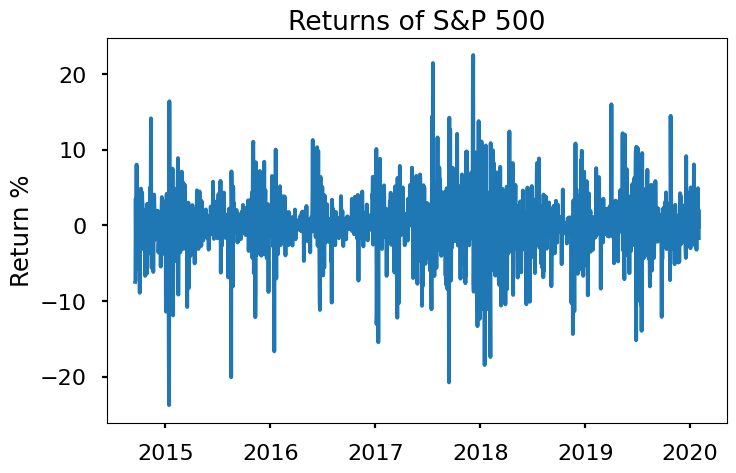

In [37]:
# Add trace plot
plt.figure(figsize=(8,5))
plt.plot(df['Return'])
plt.ylabel("Return %")
plt.title('Returns of S&P 500');

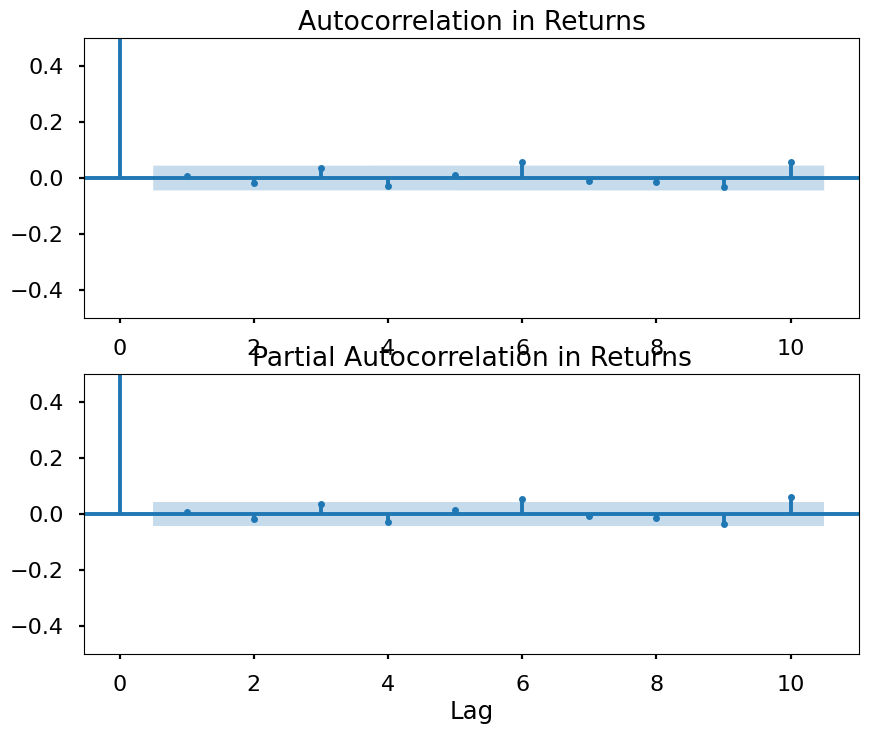

In [41]:
# Plot ACF and PACF
diff_ts = df['Return'].iloc[1:]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_ts, ax=ax1, lags=10)
ax1.set_ylim(-0.5, .5)
ax1.set_title("Autocorrelation in Returns")
plot_pacf(diff_ts, ax=ax2, lags=10)
ax2.set_ylim(-0.5, .5)
ax2.set_xlabel("Lag")
ax2.set_title("Partial Autocorrelation in Returns")

plt.show()

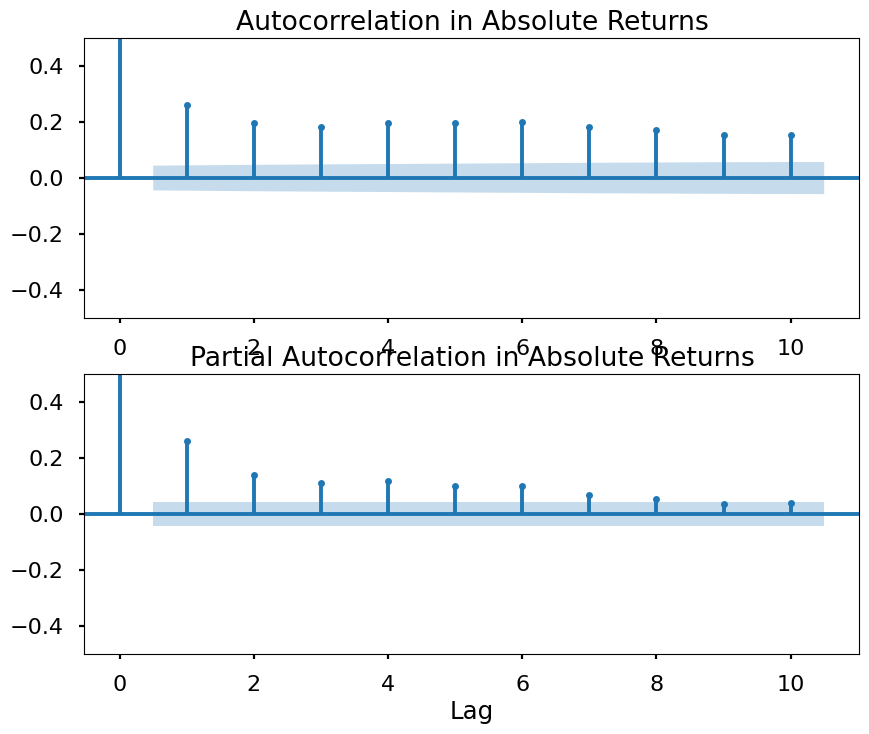

In [40]:
# Plot ACF and PACF of absolute returns
abs_returns = diff_ts.abs()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(abs_returns, ax=ax1, lags=10)
ax1.set_ylim(-.5, .5)
ax1.set_title("Autocorrelation in Absolute Returns")
plot_pacf(abs_returns, ax=ax2, lags=10)
ax2.set_ylim(-.5, .5)
ax2.set_title("Partial Autocorrelation in Absolute Returns")
ax2.set_xlabel("Lag")

plt.show();

In [42]:
def mcleod_li_test(x, k):
    """
    Calculates the McLeod-Li test statistic for a time series with k lags.
    Returns the test statistic and its p-value.
    """
    n = len(x)
    x_sq = x ** 2
    x_sum = np.sum(x_sq)
    x_lag_sum = np.sum(x_sq[:-k])
    test_stat = n * (n + 2) * x_lag_sum / (x_sum ** 2)
    df = k
    p_value = 1 - chi2.cdf(test_stat, df)
    return test_stat, p_value

In [43]:
test_stat, p_value = mcleod_li_test(abs_returns, 50)
print("McLeod-Li test statistic: ", test_stat)
print("p-value: ", p_value)

McLeod-Li test statistic:  130.8869673776336
p-value:  3.6235145994822915e-09


In [44]:
# Fit GARCH (1,1)
y_train, y_test = train_test_split(abs_returns, train_size= 0.8)

garch_mod = arch_model(y_train, mean = "Zero",  vol='Garch', p=1, q=1, rescale=False)
res_garch = garch_mod.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4680.449192352305
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5021.183313457108
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4170.621480922607
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4398.327255038773
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4169.292028791962
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4169.2918683440175
Iteration:      7,   Func. Count:     38,   Neg. LLF: 4169.291868343508
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4169.2918683440175
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7


In [45]:
# Model summary
print(res_garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -4169.29
Distribution:                  Normal   AIC:                           8344.58
Method:            Maximum Likelihood   BIC:                           8360.66
                                        No. Observations:                 1569
Date:                Fri, Sep 29 2023   Df Residuals:                     1569
Time:                        14:57:41   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3899      0.194      2.006  4.482e-02 [9.015e-0

In [46]:
# Forecast the test set
yhat = res_garch.forecast(horizon = y_test.shape[0], reindex=True)

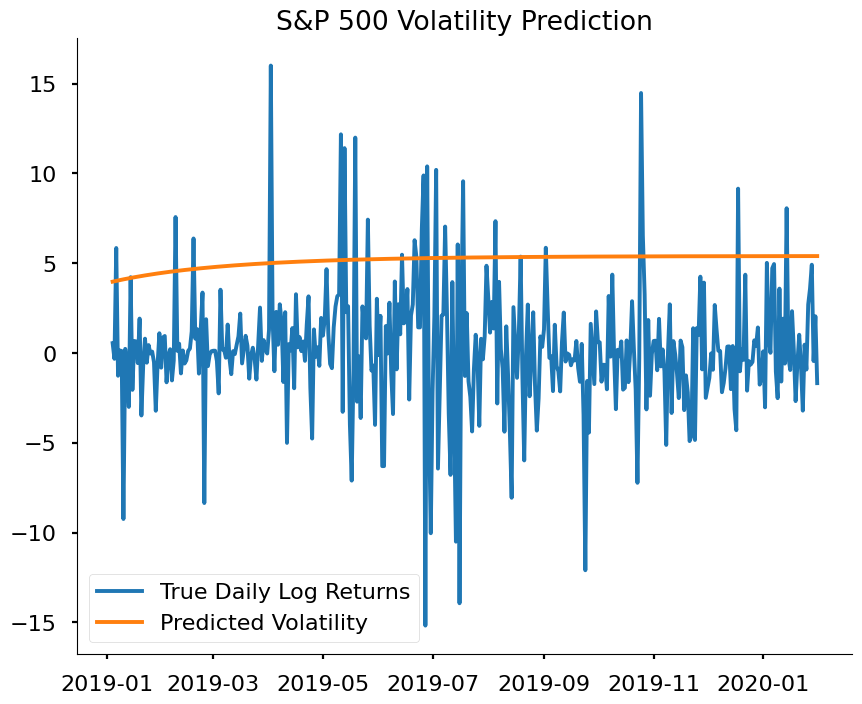

In [47]:
fig,ax = plt.subplots(figsize=(10,8))
ax.spines[['top','right']].set_visible(False)
# Plot test set returns
plt.plot(diff_ts[-y_test.shape[0]:])
# Plot volatility estimates for test set
plt.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
plt.title('S&P 500 Volatility Prediction')
plt.legend(['True Daily Log Returns', 'Predicted Volatility'])

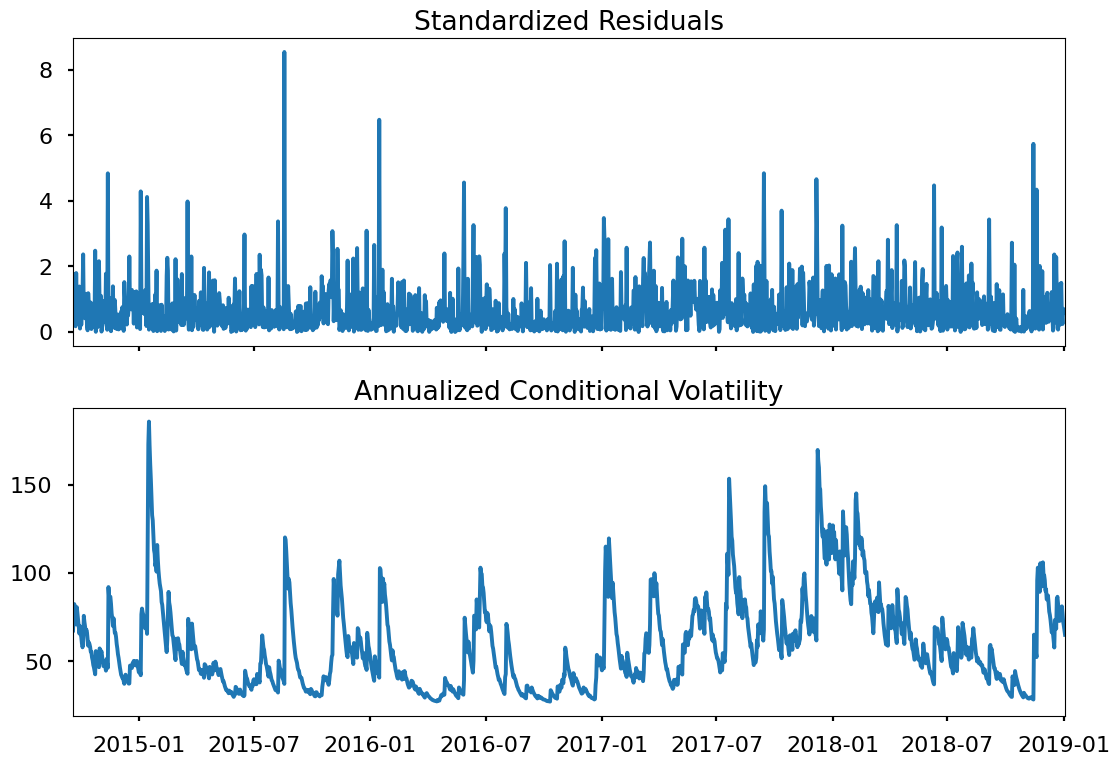

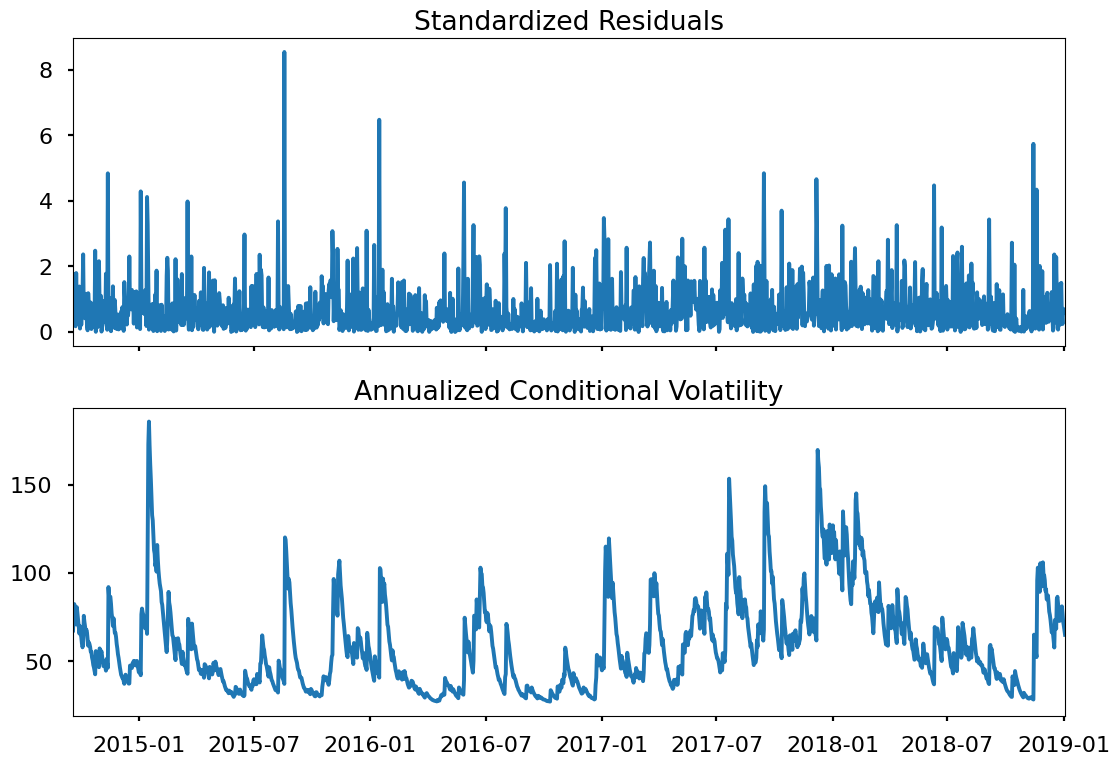

In [48]:
# Conditional volatility by model fitting
res_garch.plot(annualize="D")

In [49]:
rolling_preds = []

for i in range(y_test.shape[0]):
    train = abs_returns[:-(y_test.shape[0]-i)]
    model = arch_model(train, p=1, q=1, rescale = False)
    model_fit = model.fit(disp='off')
    # One step ahead predictor
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_preds.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_preds = pd.Series(rolling_preds, index=y_test.index)

Text(0.5, 1.0, 'S&P 500 Rolling Volatility Prediction')

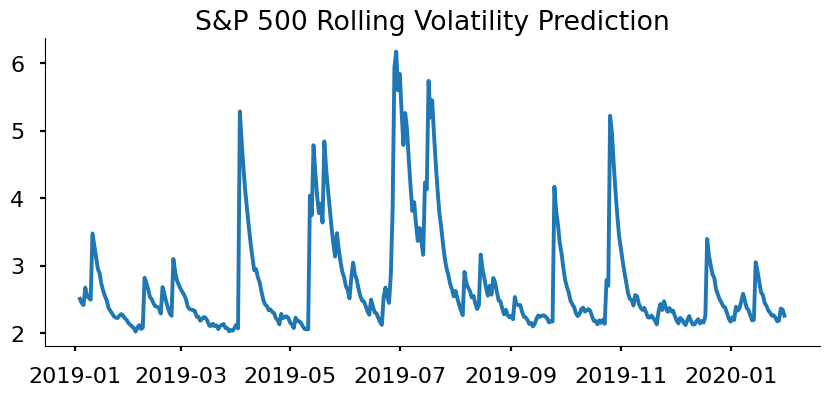

In [50]:
# Plot of predicted test data rolling volatility predictions
fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_preds)
plt.title('S&P 500 Rolling Volatility Prediction')

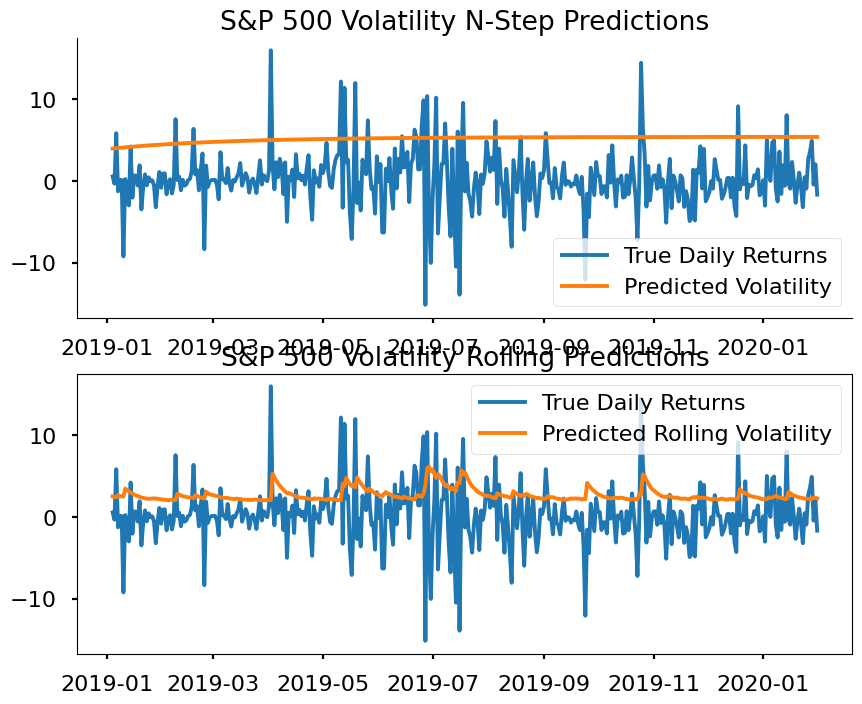

In [51]:
# Compare n-step-ahead and one-step-ahead rolling predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.spines[['top','right']].set_visible(False)
ax1.plot(diff_ts[-y_test.shape[0]:])
ax1.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
ax1.set_title("S&P 500 Volatility N-Step Predictions")
ax1.legend(['True Daily Returns', 'Predicted Volatility'])

ax.spines[['top','right']].set_visible(False)
ax2.plot(diff_ts[-y_test.shape[0]:])
ax2.plot(y_test.index,rolling_preds)
ax2.set_title("S&P 500 Volatility Rolling Predictions")
ax2.legend(['True Daily Returns', 'Predicted Rolling Volatility'])
plt.show()

In [52]:
# Calculate the standardized residuals on the test data
std_resid = res_garch.resid / res_garch.conditional_volatility

# Perform Jarque-Bera test using scipy.stats
jb_test = jarque_bera(std_resid)
print("Jarque-Bera test statistic:", jb_test[0])
print("p-value:", jb_test[1])

Jarque-Bera test statistic: 19182.530315015414
p-value: 0.0


In [53]:
rolling_preds

Date
2019-01-04 00:00:00+00:00    2.507587
2019-01-05 00:00:00+00:00    2.447834
2019-01-06 00:00:00+00:00    2.415571
2019-01-07 00:00:00+00:00    2.674775
2019-01-08 00:00:00+00:00    2.551855
                               ...   
2020-01-27 00:00:00+00:00    2.174999
2020-01-28 00:00:00+00:00    2.187336
2020-01-29 00:00:00+00:00    2.364420
2020-01-30 00:00:00+00:00    2.347598
2020-01-31 00:00:00+00:00    2.258225
Length: 393, dtype: float64

In [54]:
y_test

Date
2019-01-04 00:00:00+00:00    0.545233
2019-01-05 00:00:00+00:00    0.325149
2019-01-06 00:00:00+00:00    5.844709
2019-01-07 00:00:00+00:00    1.268470
2019-01-08 00:00:00+00:00    0.139015
                               ...   
2020-01-27 00:00:00+00:00    3.576042
2020-01-28 00:00:00+00:00    4.914066
2020-01-29 00:00:00+00:00    0.449366
2020-01-30 00:00:00+00:00    2.043704
2020-01-31 00:00:00+00:00    1.680505
Name: Return, Length: 393, dtype: float64

In [ ]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 11.2 MB/s eta 0:00:00


In [62]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


In [77]:
from arch import arch_model

# Create a GARCH model
model = arch_model(train['Close'], vol='Garch', p=1, q=1)


In [75]:
len(test)

393

In [85]:
# Forecast conditional volatility
forecasted_volatility = model_fit.forecast(horizon = len(test))


[*********************100%%**********************]  1 of 1 completed
Iteration:      1,   Func. Count:      6,   Neg. LLF: 226.80983237868864
Iteration:      2,   Func. Count:     11,   Neg. LLF: 226.53256000774653
Iteration:      3,   Func. Count:     16,   Neg. LLF: 226.54924739012523
Iteration:      4,   Func. Count:     22,   Neg. LLF: 226.4306012457452
Iteration:      5,   Func. Count:     27,   Neg. LLF: 226.43043100955305
Iteration:      6,   Func. Count:     32,   Neg. LLF: 226.43042821832378
Iteration:      7,   Func. Count:     37,   Neg. LLF: 226.430411066788
Iteration:      8,   Func. Count:     42,   Neg. LLF: 226.4303193665609
Iteration:      9,   Func. Count:     47,   Neg. LLF: 226.42984969494907
Iteration:     10,   Func. Count:     52,   Neg. LLF: 226.42752006072703
Iteration:     11,   Func. Count:     57,   Neg. LLF: 226.41696499874874
Iteration:     12,   Func. Count:     62,   Neg. LLF: 226.38915334375636
Iteration:     13,   Func. Count:     67,   Neg. LLF: 226.3

c:\Users\Abdelahi\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.263e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


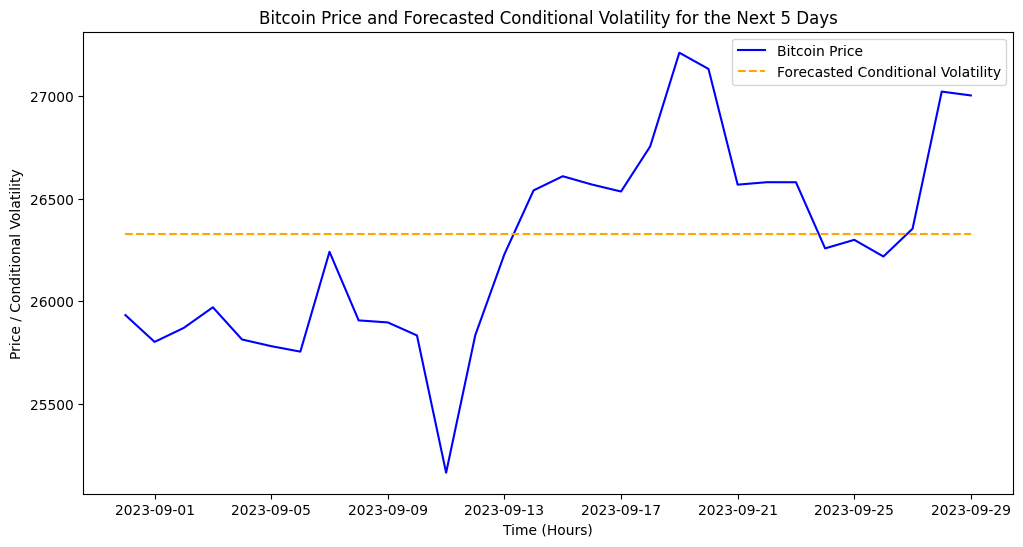

In [ ]:
import pandas as pd
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt

# Download historical Bitcoin data for the last 30 days
btc = yf.download('BTC-USD', period='30d')

# Create a DataFrame from Bitcoin data
data = pd.DataFrame({
    'date': btc.index,
    'close': btc['Close'],
    'volume': btc['Volume']
})

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Resample the data to hourly frequency
data.set_index('date', inplace=True)
data = data.resample('1H').asfreq()

# Drop rows with NaN or infinite values in the 'close' column
data.dropna(subset=['close'], inplace=True)

# Create a GARCH model
model = arch_model(data['close'], vol='Garch', p=1, q=1)

# Fit the model
model_fit = model.fit()

# Forecast conditional volatility for the next 5 days (120 hours)
forecasted_volatility_5_days = model_fit.forecast(start=0, horizon=120)

# Plot the forecasted conditional volatility along with the original data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Bitcoin Price', color='blue')
plt.plot(data.index[:30], forecasted_volatility_5_days.mean.values[-1, :30], label='Forecasted Conditional Volatility', linestyle='--', color='orange')
plt.xlabel('Time (Hours)')
plt.ylabel('Price / Conditional Volatility')
plt.legend()
plt.title('Bitcoin Price and Forecasted Conditional Volatility for the Next 5 Days')
plt.show()
